# Aggregate AP1 footprint in non-fibroblast peaks (using scATAC-seq)

Footprint of AP1 at non-fibroblast D2 sites. Assisted by bias model.

Similar to `AP1_transient_Footprint.ipynb`, which was done with multiome data. Also predicting the model predicted footprint.

In [4]:
import pyBigWig
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
# for pdf text saving 
matplotlib.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
import tensorflow as tf
import seaborn as sns
import pyfaidx
import sys
sys.path.append("/users/surag/kundajelab/chrombpnet-lite/src/")
import utils
from utils import one_hot
from utils.data_utils import get_seq
from collections import Counter
# for some seaborn warnings
import warnings; warnings.simplefilter('ignore')
from utils.loss import multinomial_nll
from metrics import softmax
import time

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    bias_model = tf.keras.models.load_model("/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.adjusted_bias_model.h5")
    xOSK_model = tf.keras.models.load_model("/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/VVoE9.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
HEADER = ['chr', 'start', 'end', 'strand', 'score', 'seq', 'imp']

In [8]:
ap1_not_fibr = pd.read_csv("./AP1.not.fibr.bed", 
                           sep='\t',
                          names=HEADER)
ap1_not_fibr.head()

,chr,start,end,strand,score,seq,imp
0,chr17,46474674,46474683,+,8.923917,GTGAGTCATG,0.577262
1,chr17,70057186,70057195,+,8.479893,ATGACTCAAC,0.323845
2,chr17,19642881,19642890,-,7.221008,GATTAGTCAC,0.311039
3,chr13,32056511,32056520,+,6.278644,ATGACACATT,0.274024
4,chr13,58087773,58087782,-,9.478803,AATGAGTCAG,0.706478


In [9]:
print(ap1_not_fibr.shape)

(10773, 7)


In [10]:
def get_vals(bw_file, regs, w=2000):
    vals = []
    bw = pyBigWig.open(bw_file)
    
    motif_half_len = (regs.iloc[0]['end'] - regs.iloc[0]['start'])//2
    
    for _, x in tqdm(regs.iterrows(), total=regs.shape[0]):
        if x['strand'] == "+":
            vals.append(np.nan_to_num(bw.values(x['chr'], x['start']+motif_half_len-w//2, x['start']+motif_half_len+w//2)))
        else:
            vals.append(np.nan_to_num(bw.values(x['chr'], x['end']-motif_half_len-w//2, x['end']-motif_half_len+w//2))[::-1])
    
    bw.close()
    
    return np.array(vals)

In [11]:
def get_seq(regs, w=2000):
    seqs = []
    motif_half_len = (regs.iloc[0]['end'] - regs.iloc[0]['start'])//2
    
    with pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta") as hg38:            
        for _, x in tqdm(regs.iterrows(), total=regs.shape[0]):
            if x['strand'] == "+":
                cur = str(hg38[x['chr']][x['start']+motif_half_len-w//2: x['start']+motif_half_len+w//2])
                seqs.append(one_hot.dna_to_one_hot([cur])[0])
            else:
                cur = str(hg38[x['chr']][x['end']-motif_half_len-w//2: x['end']-motif_half_len+w//2])
                seqs.append(one_hot.dna_to_one_hot([cur])[0][::-1, ::-1])
    
    return np.array(seqs)

In [12]:
seqs = get_seq(ap1_not_fibr)

100%|██████████| 10773/10773 [00:06<00:00, 1584.30it/s]


In [13]:
bias_pred_prof, bias_pred_cts = bias_model.predict(seqs, verbose=True)

10773/10773 [==============================] - 16s 2ms/sample


In [14]:
xOSK_pred_prof, xOSK_pred_cts = xOSK_model.predict([seqs, bias_pred_prof, bias_pred_cts], 
                                                   verbose=True)

10773/10773 [==============================] - 14s 1ms/sample


In [15]:
D2_c11 = get_vals("/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx11.bw",
                   ap1_not_fibr,
                   w=2000)

100%|██████████| 10773/10773 [00:04<00:00, 2392.22it/s]


In [16]:
# from number of lines in tagAlign files
D2_c11_DEPTH = 67544062

In [17]:
D2_c11_null = np.sum((softmax(bias_pred_prof).T * (D2_c11.sum(-1))).T, 0)
D2_c11_null = D2_c11_null/D2_c11_null.sum()

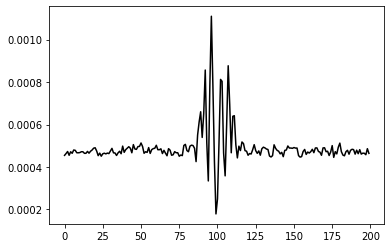

In [18]:
plt.plot(D2_c11_null[900:1100], c='k')

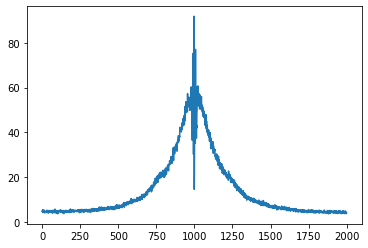

In [19]:
plt.plot(D2_c11.sum(0)/D2_c11_DEPTH*1e6)

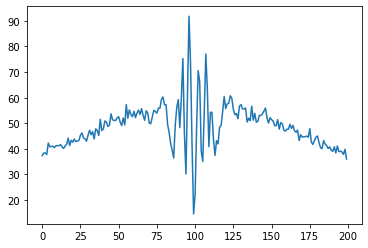

In [20]:
plt.plot((D2_c11.sum(0)/D2_c11_DEPTH*1e6)[900:1100])

In [21]:
D2_c11_corr = (D2_c11.sum(0)/D2_c11_DEPTH*1e6)/D2_c11_null

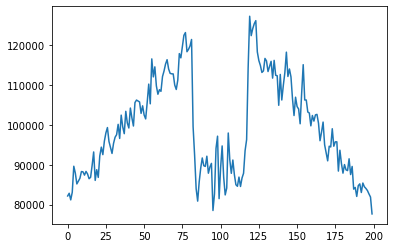

In [22]:
plt.plot(D2_c11_corr[900:1100])

In [23]:
predicted_corr = ((softmax(xOSK_pred_prof).T * (D2_c11.sum(-1)).T).sum(1)/D2_c11_DEPTH*1e6)/D2_c11_null

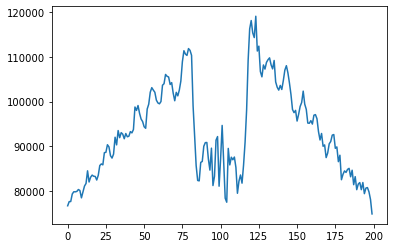

In [24]:
plt.plot(predicted_corr[900:1100])

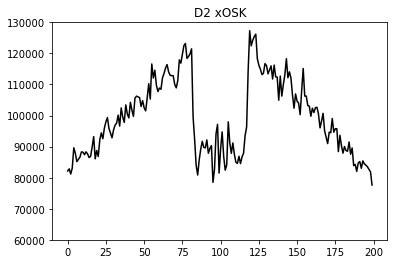

In [25]:
plt.plot(D2_c11_corr[900:1100], c='k')
plt.title("D2 xOSK")
plt.ylim(60000, 130000)
plt.savefig("./subfigs/D2.c11.scATAC.AP1.footprint.pdf")

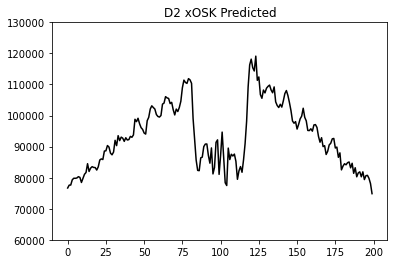

In [26]:
plt.plot(predicted_corr[900:1100], c='k')
plt.title("D2 xOSK Predicted")
plt.ylim(60000, 130000)
plt.savefig("./subfigs/D2.c11.scATAC.predicted.AP1.footprint.pdf")